In [ ]:
# 25 marks

In [2]:
# Import libraries

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, zscore
from sklearn.datasets import fetch_california_housing
import pymc3 as pm
import arviz as az

In [3]:
# Load California housing dataset

california_housing = fetch_california_housing(as_frame=True)
x = california_housing.data
print(x.shape)
y = california_housing.target
print(y.shape)

(20640, 8)
(20640,)


In [5]:
# Preprocess datapoints

if x.isnull().sum()[1] > 0:
    print("null values need to be removed")
else:
    print("data has no null values")
rmv_outlier_data_x = x[(np.abs(zscore(x)) < 3).all(axis=1)]
rmv_outlier_data_y = y[(np.abs(zscore(x)) < 3).all(axis=1)]
print("Removed", x.shape[0] - rmv_outlier_data_x.shape[0], "outlier rows")
print("Target value counts:", y.value_counts().head(1))
rmv_silly_high_vals_x = rmv_outlier_data_x[rmv_outlier_data_y != 5.00001]
rmv_silly_high_vals_y = rmv_outlier_data_y[rmv_outlier_data_y != 5.00001]
print("Removed", rmv_outlier_data_x.shape[0] - rmv_silly_high_vals_x.shape[0], "skewed rows")

data has no null values
Removed 846 outlier rows
Target value counts: 5.00001    965
Name: MedHouseVal, dtype: int64
Removed 670 skewed rows


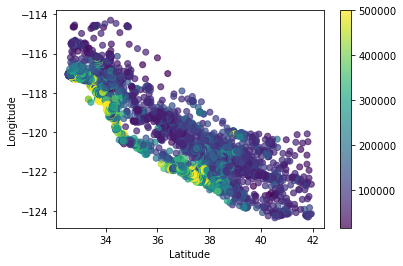

In [6]:
# Plot how longitude and latitude affect median house price

latitudes = x['Latitude']
longitudes = x['Longitude']
plt.scatter(latitudes, longitudes, c=y*100000, alpha=0.7)
plt.colorbar()
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.show()

In [ ]:
# Use PyMC to get approximate posterior distributions over each model parameter

model = pm.Model()

with model:
    #w0 = pm.Normal('w0', mu=0, sigma=20)
    #w1 = pm.Normal('w1', mu=0, sigma=20)
    #sigma = pm.Uniform('sigma', lower=0, upper=20)
    #y_est = w0 + w1 * x
    #likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y)
    
    beta = pm.Normal('beta', mu=0, sd=3, shape=(8, 1))
    intercept = pm.Normal('intercept', mu=0, sd=3)
    std = pm.HalfNormal('std', sd=5)
    y_est = intercept + pm.math.dot(x, beta)
    likelihood = pm.Normal('y_lik', mu=y_est, sd=std, observed = y)

    sampler = pm.NUTS()
    posterior = pm.sample(sampler, progressbar=True, cores=2, chains=2)
    print(az.summary(posterior))
    az.plot_trace(posterior)
    plt.show()

In [20]:
az.summary(posterior, round_to=2)

/Users/lucy/opt/anaconda3/envs/ML_labs/lib/python3.10/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w0,2.07,0.0,2.06,2.08,0.0,0.0,1929.27,1473.35,1.0
w1,-0.00,0.0,-0.00,-0.00,0.0,0.0,1981.49,1383.53,1.0
sigma,1.15,0.0,1.15,1.16,0.0,0.0,2031.81,984.54,1.0
